In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import utile
import matplotlib.pyplot as plt
from torch.utils.data import  Dataset,random_split,DataLoader

In [2]:
batch_size = 256
num_worker = 0

In [3]:
# 定义一个名为 plot_series 的函数，用于绘制时间序列图
def plot_series(time, plot_series, format='-', start=0, end=None, label=None):
    # 使用 matplotlib 绘制时间序列图
    plt.plot(time[start:end], plot_series[start:end], format, label=label)
    plt.xlabel("Time")  # x轴标签
    plt.ylabel("Value")  # y轴标签
    if label:  # 如果提供了标签
        plt.legend(fontsize=14)  # 显示图例
    plt.grid(True)  # 显示网格
    plt.show()  # 显示图像


In [4]:
# 定义名为 trend 的函数，用于生成趋势数据
def trend(time, slope=0):
    """
    生成趋势数据。

    参数:
    time (list): 时间的列表。
    slope (float): 坡度，默认为0。
    """
    return (slope * time)

# 定义名为 whtie_noise 的函数，用于生成白噪声数据
def whtie_noise(time, std=1.0, seed=None):
    """
    生成白噪声数据。

    参数:
    time (list): 时间的列表。
    std (float): 标准差，默认为1.0。
    seed (int): 种子数，默认为None。
    """
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * std

# 定义名为 seasonal_pattern 的函数，用于生成季节性模式数据
def seasonal_pattern(season_time):
    """
    生成季节性模式数据。

    参数:
    season_time (list): 季节时间的列表。
    """
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

# 定义名为 seasonality 的函数，用于生成季节性数据
def seasonality(time, period, amplitude=1, phase=0):
    """
    生成季节性数据。

    参数:
    time (list): 时间的列表。
    period (int): 周期数。
    amplitude (int): 振幅，默认为1。
    phase (int): 相位，默认为0。
    """
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
def train_test_split(series, split_fraction=0.7):
    """
    将数据集划分为训练集和测试集。

    参数:
    series (list): 输入的时间序列数据。
    split_fraction (float): 划分的比例，默认为0.7。

    返回:
    train_set (list): 训练集数据。
    test_set (list): 测试集数据。
    """
    train_size = int(len(series) * split_fraction)
    train_set = series[:train_size]
    test_set = series[train_size:]
    return train_set, test_set


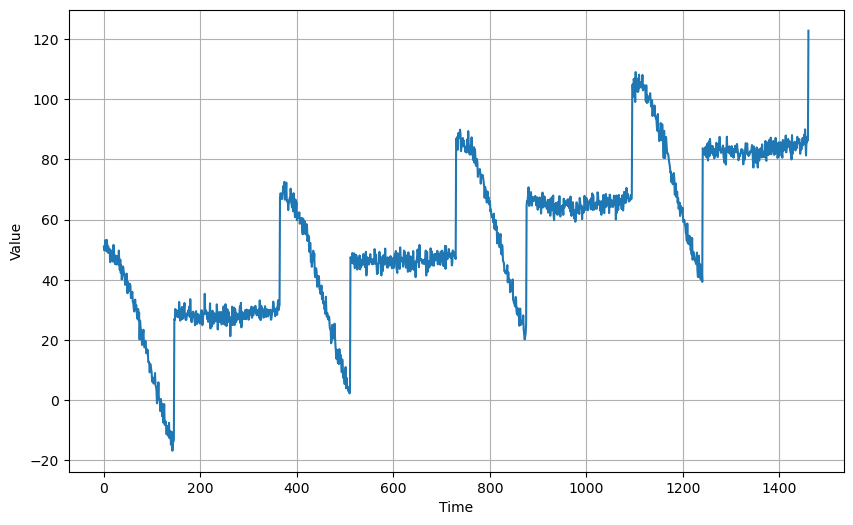

In [5]:

time = np.arange(4 * 365 + 1)
baseline = 10
slope = 0.05
amplitude = 40
noise_level = 2

# 生成时间序列数据
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + whtie_noise(time, noise_level, seed=42)
series = series.astype(np.double)

# 绘制时间序列图
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()


In [6]:
class my_Dataset(Dataset):
    def __init__(self, features, labels):
        self.X = features  # 存储特征数据
        self.y = labels  # 存储标签数据

    def __getitem__(self, index):
        return self.X[index], self.y[index]  # 获取指定索引的特征和标签数据

    def __len__(self):
        return self.X.shape[0]  # 返回数据集的大小

class TrafficDataset:
    def __init__(self, Data=None, sensor=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = Data  # 存储原始数据
        print(self.raw_data.shape)  # 打印原始数据形状
        self.sensor = sensor  # 设置传感器数
        self.target = target  # 设置目标值

        # 数据标准化
        self.min = self.raw_data.min()  # 获取数据最小值
        self.max = self.raw_data.max()  # 获取数据最大值
        self.data = (self.raw_data - self.min) / (self.max - self.min)  # 对数据进行标准化处理

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min  # 对数据进行反标准化处理

    def construct_set(self, window_size=6, split=0.7):
        train_x = []  # 存储训练集特征
        train_y = []  # 存储训练集标签
     
        test_x = []  # 存储测试集特征
        test_y = []  # 存储测试集标签

        len_train = int(self.raw_data.shape[0] * split)  # 计算训练集长度
        train_seqs = self.data[:len_train]  # 获取训练集数据
        remain_len = len_train+int((self.raw_data.shape[0] - len_train)/2)  # 计算剩余长度

        # 构建训练集
        for i in range(train_seqs.shape[0] - window_size):
            train_x.append(train_seqs[i:i+window_size].squeeze())  # 构建训练集特征
            train_y.append(train_seqs[i+window_size].squeeze())  # 构建训练集标签

        # 构建测试集
        test_seqs=self.data[len_train:]
        for i in range(test_seqs.shape[0] - window_size):
            test_x.append(test_seqs[i:i+window_size].squeeze())  # 构建测试集特征
            test_y.append(test_seqs[i+window_size].squeeze())  # 构建测试集标签
        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))  # 创建训练集数据集实例
       
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))  # 创建测试集数据集实例
        return train_set, test_set  # 返回训练集和测试集数据集实例

# 实例化TrafficDataset类并构建数据集
t = TrafficDataset(series)
train_set, test_set = t.construct_set()
print(train_set.__len__(), test_set.__len__())

# 构建数据加载器
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_worker, drop_last=True)  # 训练集数据加载器
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_worker, drop_last=True)  # 测试集数据加载器


(1461,)
1016 433


C:\Users\zx131\AppData\Local\Temp\ipykernel_31036\3496585937.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))  # 创建训练集数据集实例


In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()  # 调用父类的构造函数
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)  # 定义RNN层
        self.linear = nn.Linear(hidden_size, output_size)  # 定义线性层

    def forward(self, x):
        out, _ = self.rnn(x)  # RNN层的前向传播

        out = self.linear(out[:, -1, :])  # 取最后一个时间步的输出，通过线性层得到最终输出
        return out  # 返回输出结果


In [8]:
rmse, mae = [], []  # 初始化 RMSE 和 MAE 列表
train_loss=[]  # 初始化训练损失列表
test_loss=[]  # 初始化测试损失列表

# 训练参数设置
epoch_num = 2500  # 迭代次数
lr = 0.00001  # 学习率
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 选择设备（如果有 GPU 则选择 GPU，否则选择 CPU）

# 创建 RNN 模型实例并将其移到所选设备
model = RNN(1, 100, 1, 5).to(device)

# 定义优化器和损失函数
opt = torch.optim.Adam(model.parameters(), lr=lr)
loss = nn.MSELoss()

# 训练循环
for epoch in range(epoch_num):
    loss_list=[]  # 初始化损失列表

    # 遍历训练数据
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        # 前向传播
        out = model(x.unsqueeze(2))

        # 计算损失
        l = loss(out, y.unsqueeze(1))

        # 清除梯度、反向传播、更新权重
        opt.zero_grad()
        l.backward()
        opt.step()
        loss_list.append(l.item())
    train_loss_mean = np.mean(loss_list)
    train_loss.append(train_loss_mean)
    loss_list = []
    rmse_list, mae_list = [], []

    # 遍历测试数据
    for x, y in test_loader:
        if x.shape[0] < batch_size:
            continue
        x, y = x.to(device), y.to(device)
        y_hat = model(x.unsqueeze(2))
        l = loss(y_hat, y.unsqueeze(1))

        # 反标准化预测值和真实值，并计算 RMSE 和 MAE
        y = t.denormalize(y)
        y_hat = t.denormalize(y_hat)
        rmse_a, mae_a = utile.eval(y.detach(), y_hat.detach())
        rmse_list.append(rmse_a)
        mae_list.append(mae_a)
        loss_list.append(l.item())

    test_loss_mean = np.mean(loss_list)
    test_loss.append(test_loss_mean)
    rmse.append(np.mean(rmse_list))
    mae.append(np.mean(mae_list))

    # 打印指标信息
    print("epoch:", epoch + 1, "\n",
              "train_loss:", train_loss_mean, "test_loss:", test_loss_mean,
                "\n",
              "mae:", np.mean(mae_list),
              "rmse:", np.mean(rmse_list)
              )


epoch: 1 
 train_loss: 0.2280594209829966 test_loss: 0.48123136162757874 
 mae: 94.529854 rmse: 96.77538224866385
epoch: 2 
 train_loss: 0.2178948571284612 test_loss: 0.45618778467178345 
 mae: 91.73137 rmse: 94.22361616786951
epoch: 3 
 train_loss: 0.2058384915192922 test_loss: 0.4397186040878296 
 mae: 90.31392 rmse: 92.50715766225876
epoch: 4 
 train_loss: 0.1989605873823166 test_loss: 0.4242438077926636 
 mae: 88.643234 rmse: 90.86480126746
epoch: 5 
 train_loss: 0.19182443618774414 test_loss: 0.40926581621170044 
 mae: 86.85981 rmse: 89.24639457878676
epoch: 6 
 train_loss: 0.1808872769276301 test_loss: 0.41502952575683594 
 mae: 87.52801 rmse: 89.87262579444032
epoch: 7 
 train_loss: 0.17325163384278616 test_loss: 0.40353116393089294 
 mae: 86.098465 rmse: 88.61892279057842
epoch: 8 
 train_loss: 0.1668243408203125 test_loss: 0.385957270860672 
 mae: 83.92512 rmse: 86.6677524596447
epoch: 9 
 train_loss: 0.15552518765131632 test_loss: 0.3659002184867859 
 mae: 81.776825 rmse: 84.

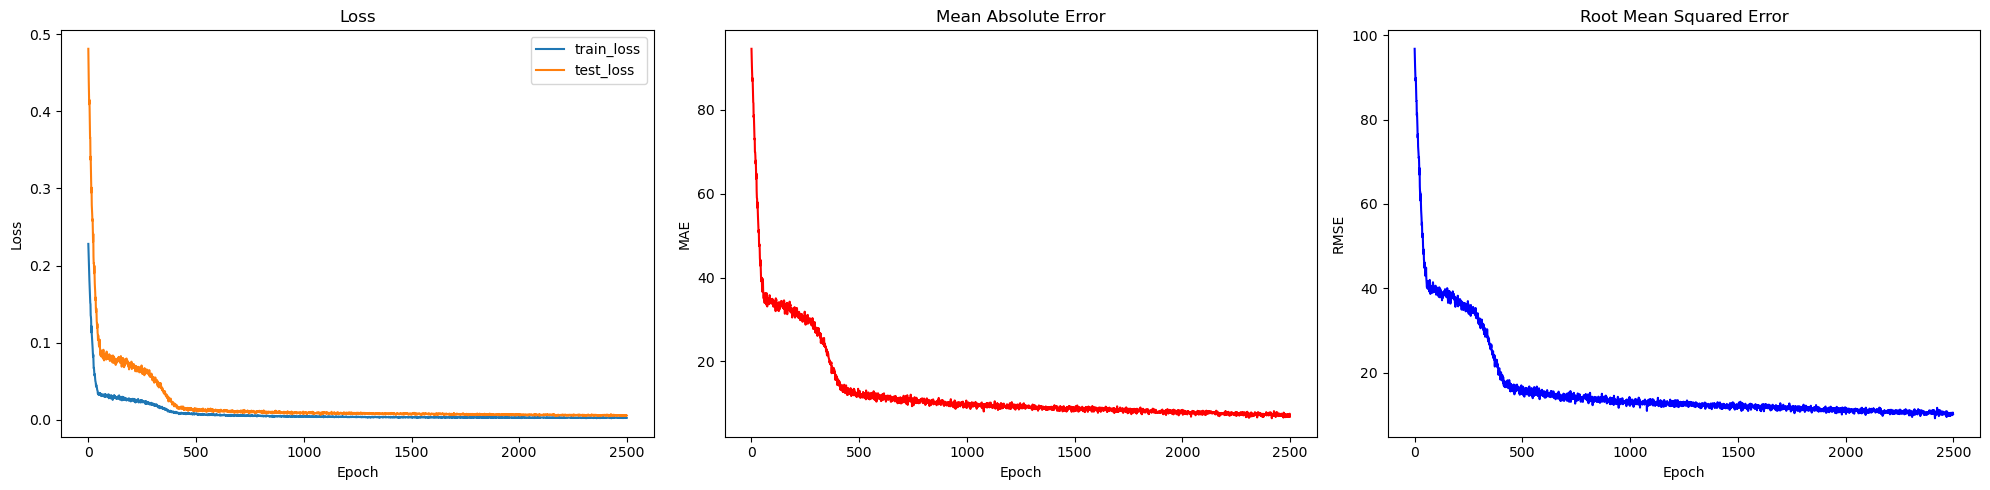

In [9]:
utile.show_result(train_loss,test_loss,mae,rmse)

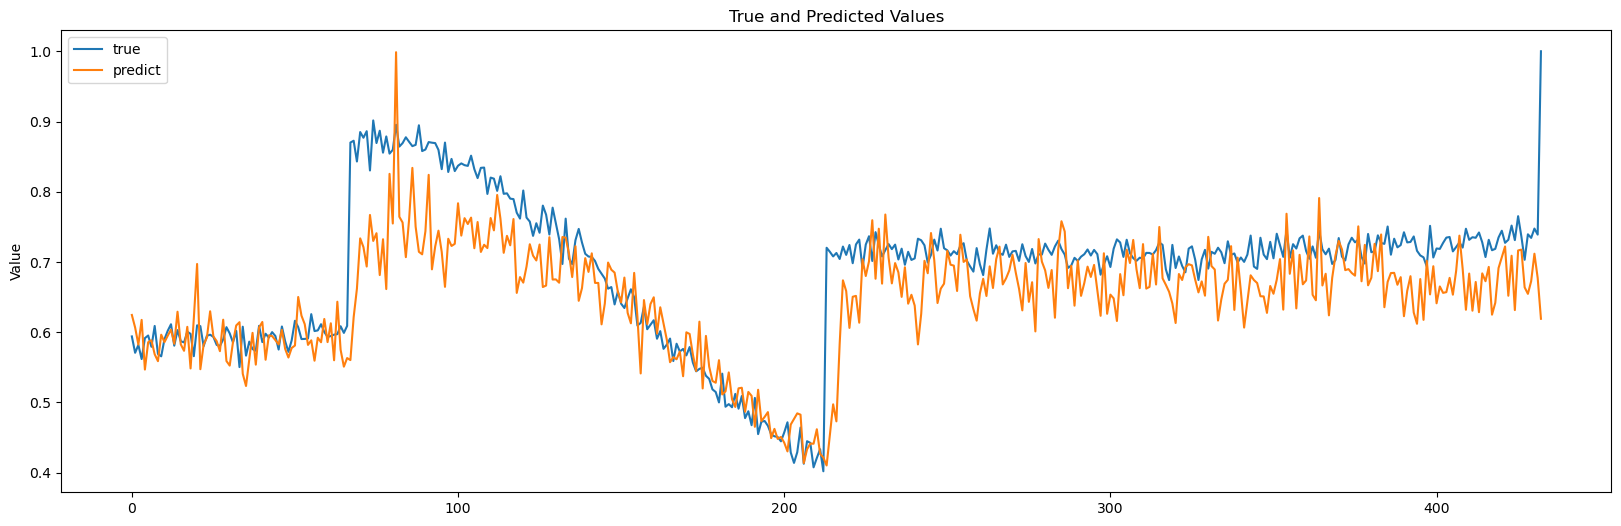

In [10]:
def plot_predictions(net, test_feature, test_label, split_prop, series):
    """
    绘制预测结果和真实结果的图表。

    参数:
    net (ConvModel): 训练好的模型。
    test_feature (Tensor): 测试集特征数据。
    test_label (Tensor): 测试集标签数据。
    split_prop (float): 分割比例。
    series (list): 数据集。

    """
    # 使用训练好的模型进行预测
    test_predict = net(test_feature.unsqueeze(2).to(device)).squeeze().tolist()
    split_point = int(split_prop * int(series.size))
    test_true = test_label

    # 绘制真实值和预测值的对比图表
    plt.figure(figsize=(20, 6))
    plt.plot(test_true, label='true')  # 绘制真实值曲线
    plt.plot(test_predict, label='predict')  # 绘制预测值曲线
    plt.ylabel('Value')  # 设置纵坐标标签
    plt.title('True and Predicted Values')  # 设置图表标题
    plt.legend()  # 添加图例
    plt.show()  # 展示图表
# print(*test_set)
plot_predictions(model, test_set[:][0], test_set[:][1], 0.6, series)

# 实验结果分析

与CNN网络相比，LSTM网络和RNN网络性能得到了非常巨大的提升，RNN可以很好的捕获时间序列数据的特征

但是数据的波动性依旧较高，较为不清晰。